In [1]:
import os
import time
import numpy as np
import shutil
import cv2
import pickle
import itertools

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm import tqdm

In [2]:
import mediapipe as mp

In [3]:
hands = mp.solutions.hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5)

drawing = mp.solutions.drawing_utils

In [4]:
def frame_extract(path):
    vcap = cv2.VideoCapture(path)
    while True:
        ret, frame = vcap.read()
        if not ret:
            break
            
        height, width = frame.shape[:2]
        img = frame
        img = cv2.resize(frame, (640, int(height * (640 / width))))
        img = img[:, :, ::-1]
        yield img

In [5]:
def process(image, preview=False):
    if preview:
        preview_image = image.copy()
        
    outputs = hands.process(image)
    
    shape = (len(mp.solutions.hands.HandLandmark), 2)
    
    multi_coords = []
    if outputs.multi_hand_landmarks:
        for landmarks in outputs.multi_hand_landmarks:
            coords = np.zeros(shape)
            if preview:
                drawing.draw_landmarks(preview_image, landmarks, mp.solutions.hands.HAND_CONNECTIONS)
                
            for landmark_type in mp.solutions.hands.HandLandmark:
                landmark = landmarks.landmark[landmark_type]
                coords[landmark_type] = (landmark.x, landmark.y)
                
            multi_coords.append(coords)
            
    if preview:
        return multi_coords, preview_image
    
    return multi_coords

In [6]:
def generate(image, coords, keep_scale=True):
    coords = coords * image.shape[1::-1]
    min_x, min_y = np.amin(coords, axis=0)
    max_x, max_y = np.amax(coords, axis=0)
    
    if keep_scale:
        ratio = max(max_x - min_x, max_y - min_y)
    else:
        ratio = (max_x - min_x, max_y - min_y)
    coords = (coords - (min_x, min_y)) / ratio
    
    w, h = 32, 32
    image = np.zeros((h, w, 1), dtype=np.uint8)
    for x, y in coords:
        image[round(y * (h - 1)), round(x * (w - 1))] = 255
    
    return image, coords

In [7]:
def save(path, image):
    cv2.imwrite(path, image[..., ::-1])
    
def mkdir(path, clear=True):
    if not os.path.isdir(path):
        os.mkdir(path)
    elif clear:
        shutil.rmtree(path)
        os.mkdir(path)
        
def save_pkl(path, obj):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
        
def load_pkl(path):
    with open(path, 'rb') as file:
        obj = pickle.load(file)
    return obj
        
def save_npy(path, arr):
    with open(path, 'wb') as file:
        np.save(file, arr)
        
def load_npy(path):
    with open(path, 'rb') as file:
        arr = np.load(file)
    return arr

In [8]:
def process_video(class_name, video_name, verbose=False, warm_up=True):
    video_path = os.path.join('data', 'videos', class_name, video_name)
    class_dir = os.path.join('data', 'frames', class_name)
    frame_dir = os.path.join(class_dir, os.path.splitext(video_name)[0])
    preview_dir = os.path.join(frame_dir, 'preview')
    coords_dir = os.path.join(frame_dir, 'coords')

    if os.path.isdir(frame_dir):
        return video_path, frame_dir
    
    mkdir(class_dir, clear=False)
    mkdir(frame_dir)
    mkdir(preview_dir)
    mkdir(coords_dir)

    if verbose:
        print(video_path, frame_dir)

    landmarks = []
    
    if warm_up:
        for frame in frame_extract(video_path):
            hands.process(frame)
            
        frame_0, frame_1 = itertools.islice(frame_extract(video_path), 2)
        for _ in range(50):
            hands.process(frame_0)
            hands.process(frame_1)

    for i, frame in enumerate(frame_extract(video_path)):
        multi_coords, preview_image = process(frame, preview=True)

        preview_path = os.path.join(preview_dir, f'{i}.jpg')
        save(preview_path, preview_image)

        if verbose:
            if i == 0:
                plt.imshow(preview_image)
                plt.show()

        normalized_coords = []
        for j, coords in enumerate(multi_coords):
            image, coords = generate(frame, coords)
            normalized_coords.append(coords)

            coords_path = os.path.join(coords_dir, f'{i}_{j}.bmp')
            save(coords_path, image)

            if verbose:
                if i == 0:
                    plt.imshow(image, cmap='gray')
                    plt.show()

                    print(coords.shape)
                    print(coords)

        landmarks.append(normalized_coords)

    landmarks_path = os.path.join(frame_dir, 'landmarks.pkl')
    save_pkl(landmarks_path, landmarks)

    data = np.zeros((len(landmarks), 21, 2))
    for i, multi_coords in enumerate(landmarks):
        if len(multi_coords) > 0:
            data[i] = multi_coords[0]
    data_path = os.path.join(frame_dir, 'data.npy')
    save_npy(data_path, data)
    
    return video_path, frame_dir

In [9]:
videos_dir = os.path.join('data', 'videos')
for class_name in os.listdir(videos_dir):
    class_dir = os.path.join(videos_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    print(class_name)
    for video_name in os.listdir(class_dir):
        if not os.path.splitext(video_name)[1] == '.mp4':
            continue
        video_path, frame_dir = process_video(class_name, video_name, verbose=False)
        print('-', video_path, frame_dir)

cursor
- data\videos\cursor\20210830_101259.mp4 data\frames\cursor\20210830_101259
- data\videos\cursor\20210830_101316.mp4 data\frames\cursor\20210830_101316
- data\videos\cursor\20210830_101328.mp4 data\frames\cursor\20210830_101328
- data\videos\cursor\20210830_101346.mp4 data\frames\cursor\20210830_101346
- data\videos\cursor\20210830_101405.mp4 data\frames\cursor\20210830_101405
- data\videos\cursor\20210830_143837.mp4 data\frames\cursor\20210830_143837
- data\videos\cursor\20210830_143907.mp4 data\frames\cursor\20210830_143907
- data\videos\cursor\20211006_144751.mp4 data\frames\cursor\20211006_144751
- data\videos\cursor\20211006_144840.mp4 data\frames\cursor\20211006_144840
- data\videos\cursor\20211006_144928.mp4 data\frames\cursor\20211006_144928
- data\videos\cursor\20211006_145002.mp4 data\frames\cursor\20211006_145002
fist
- data\videos\fist\20210830_101200.mp4 data\frames\fist\20210830_101200
- data\videos\fist\20210830_101215.mp4 data\frames\fist\20210830_101215
- data\v

In [10]:
if False:
    class_name = 'point'
    video_name = '20210819_100907.mp4'
    video_path, frame_dir = process_video(class_name, video_name, verbose=True)
    
    print(load_npy(os.path.join(frame_dir, 'data.npy'))[0])

In [11]:
def flip_y_fn(coords):
    flipped = np.copy(coords)
    flipped[..., 0] = np.amax(coords[..., 0]) - coords[..., 0]
    return flipped

(21, 2)


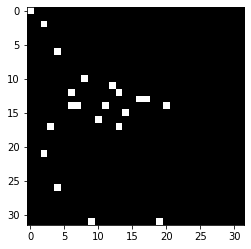

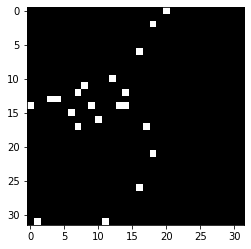

In [12]:
coords = load_npy(os.path.join('data/frames/point/20210819_100850', 'data.npy'))[0]

print(coords.shape)
#print(coords)
#print(flip_y(coords))

w, h = 32, 32
image = np.zeros((h, w, 1), dtype=np.uint8)
for x, y in coords:
    image[round(y * (h - 1)), round(x * (w - 1))] = 255
    
plt.imshow(image, cmap='gray')
plt.show()

coords = flip_y_fn(coords)

w, h = 32, 32
image = np.zeros((h, w, 1), dtype=np.uint8)
for x, y in coords:
    image[round(y * (h - 1)), round(x * (w - 1))] = 255
    
plt.imshow(image, cmap='gray')
plt.show()

In [13]:
def load_data():
    data = {}
    data_dir = os.path.join('data', 'frames')
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        print(class_name)
        items = []
        for video_name in os.listdir(class_dir):
            video_dir = os.path.join(class_dir, video_name)
            if not os.path.isdir(video_dir):
                continue
            data_path = os.path.join(video_dir, 'data.npy')
            item = load_npy(data_path)
            items.append(item)
            print(item.shape)
        data[class_name] = items
        
    return data
            
data = load_data()

cursor
(317, 21, 2)
(187, 21, 2)
(126, 21, 2)
(356, 21, 2)
(251, 21, 2)
(492, 21, 2)
(969, 21, 2)
(1104, 21, 2)
(793, 21, 2)
(792, 21, 2)
(743, 21, 2)
fist
(217, 21, 2)
(164, 21, 2)
(183, 21, 2)
(145, 21, 2)
(530, 21, 2)
(274, 21, 2)
grab
(160, 21, 2)
(215, 21, 2)
(148, 21, 2)
(278, 21, 2)
(212, 21, 2)
(222, 21, 2)
(284, 21, 2)
(355, 21, 2)
(853, 21, 2)
(873, 21, 2)
negative
(140, 21, 2)
(131, 21, 2)
(273, 21, 2)
(590, 21, 2)
(807, 21, 2)
(1043, 21, 2)
(879, 21, 2)
(745, 21, 2)
palm
(167, 21, 2)
(168, 21, 2)
(240, 21, 2)
(1631, 21, 2)
(484, 21, 2)
(194, 21, 2)
point
(128, 21, 2)
(181, 21, 2)
(173, 21, 2)
(173, 21, 2)
(172, 21, 2)
(181, 21, 2)
(150, 21, 2)
(138, 21, 2)
(121, 21, 2)
(257, 21, 2)
(391, 21, 2)
(247, 21, 2)
(256, 21, 2)
(456, 21, 2)
(154, 21, 2)
(162, 21, 2)
(200, 21, 2)
(213, 21, 2)
(219, 21, 2)
thumb
(145, 21, 2)
(170, 21, 2)
(117, 21, 2)
(97, 21, 2)
(136, 21, 2)
(155, 21, 2)
(192, 21, 2)
(198, 21, 2)
(126, 21, 2)
(215, 21, 2)
(41, 21, 2)
(480, 21, 2)
(802, 21, 2)
(919, 2

In [14]:
len(data['point'])

19

In [54]:
# frame
total = 0
for class_name in data:
    n_frames = np.sum([len(item) for item in data[class_name]])
    total += n_frames
    print(class_name, n_frames)
    
print('total', total)

cursor 6130
fist 1513
grab 3600
negative 4608
palm 2884
point 3972
thumb 3793
total 26500


In [15]:
def sliding_window(sequence, timesteps=10, strides=1):
    n = len(sequence)
    steps = (n - timesteps) // strides + 1
    # print(n, steps)
    for i in range(steps):
        start = i * strides
        end = start + timesteps
        # print(start, end)
        yield sequence[start:end]

In [16]:
for seq in sliding_window(range(20), timesteps=10, strides=1):
    print(seq)
#     print(seq)

range(0, 10)
range(1, 11)
range(2, 12)
range(3, 13)
range(4, 14)
range(5, 15)
range(6, 16)
range(7, 17)
range(8, 18)
range(9, 19)
range(10, 20)


In [17]:
def from_sequences(sequences, labels, flip_y=True):
    for sequence in sequences:
        for features in sliding_window(sequence):
            #print(features.shape)
            yield tf.expand_dims(features, axis=1), labels
            if flip_y:
                #print(flip_y_fn(features))
                yield tf.expand_dims(flip_y_fn(features), axis=1), labels

In [18]:
classes = ['cursor', 'fist', 'grab', 'negative', 'palm', 'point', 'thumb']
n_classes = len(classes)
encoding = tf.one_hot(range(n_classes), n_classes)
print(encoding)

def label_encoding(class_name):
    return encoding[classes.index(class_name)]

input_shape = (10, 1, 21, 2)
output_shape = (n_classes,)

print(input_shape, output_shape)

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]], shape=(7, 7), dtype=float32)
(10, 1, 21, 2) (7,)


In [19]:
label_encoding('palm')

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

In [20]:
def dataset_from_class(class_name):
    def gen():
        yield from from_sequences(data[class_name], label_encoding(class_name))

    dataset = tf.data.Dataset.from_generator(
        gen, 
        output_signature=(
            tf.TensorSpec(shape=input_shape), 
            tf.TensorSpec(shape=output_shape, )))
    
    return dataset

In [21]:
dataset_classes = []
for class_name in classes:
    dataset = dataset_from_class(class_name)
    print(class_name, len(list(dataset)))
    dataset_classes.append(dataset)

cursor 12062
fist 2918
grab 7020
negative 9072
palm 5660
point 7602
thumb 7334


In [22]:
full_dataset = tf.data.experimental.sample_from_datasets(dataset_classes)
print(len(list(full_dataset)))

51668


In [23]:
# sampled_dataset = tf.data.experimental.sample_from_datasets(
#     [dataset_palm.repeat(), dataset.repeat()])

sampled_dataset = tf.data.experimental.sample_from_datasets(
    [dataset.repeat() for dataset in dataset_classes])

# sampled_dataset = tf.data.experimental.sample_from_datasets(dataset_classes)

total = tf.zeros((7,))
for features, labels in sampled_dataset.shuffle(100).take(10000):
    print(labels)
    total += labels

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1

tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1

tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0

tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0

tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0

tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0

In [24]:
total

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([1363., 1387., 1444., 1421., 1447., 1431., 1507.], dtype=float32)>

tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)


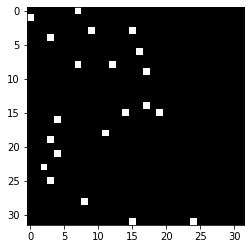

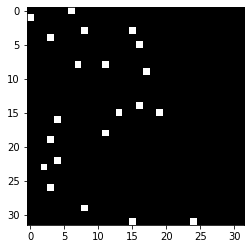

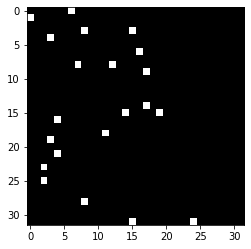

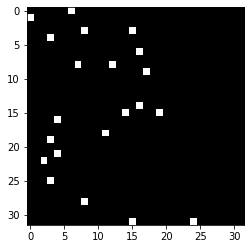

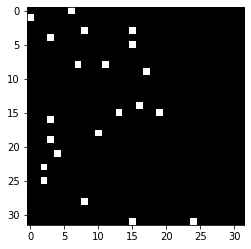

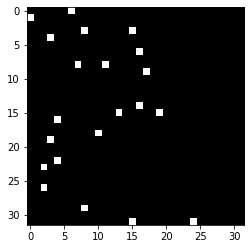

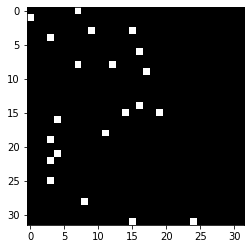

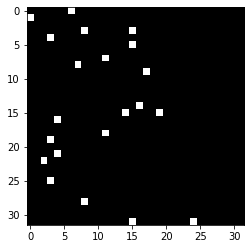

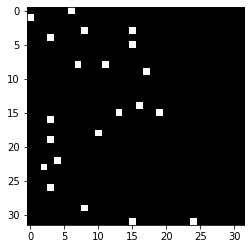

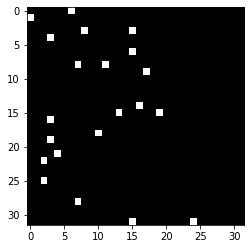

(10, 1, 21, 2) (7,)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)


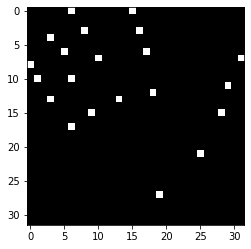

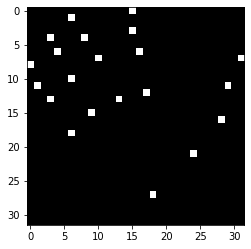

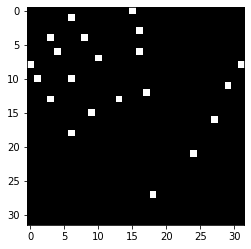

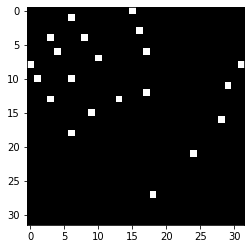

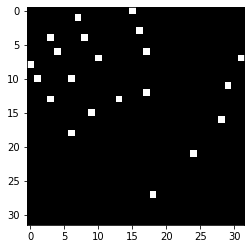

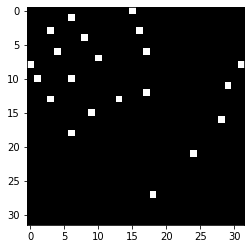

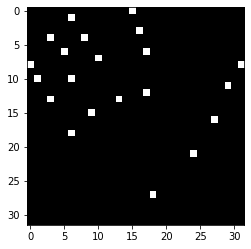

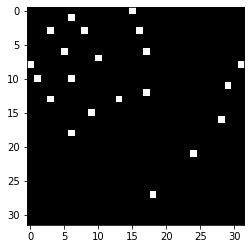

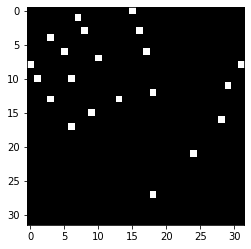

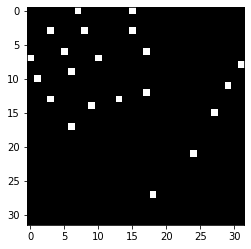

(10, 1, 21, 2) (7,)


In [25]:
for features, labels in sampled_dataset.take(2):
    print(labels)
    for coords in features:
        coords = np.asarray(coords[0])
        w, h = 32, 32
        image = np.zeros((h, w, 1), dtype=np.uint8)
        for x, y in coords:
            image[round(y * (h - 1)), round(x * (w - 1))] = 255

        plt.imshow(image, cmap='gray')
        plt.show()
        
    print(features.shape, labels.shape)

In [26]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [31]:
def neural_net(input_shape, output_shape):
    inputs = Input(input_shape)
    x = inputs
    x = tf.keras.layers.Conv2D(32, (1, 3), activation='relu')(x)
    x = tf.keras.layers.Reshape((10, -1))(x)
#     x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(100)(x)
#     x = Dense(100, activation='relu')(x)
    x = Dense(output_shape[0], activation='softmax')(x)
    outputs = x
    
    return Model(inputs, outputs)

In [32]:
np.__version__

'1.19.3'

In [33]:
model = neural_net((10, 1, 21, 2), output_shape)
model.compile(
    optimizer=Adam(lr=1e-3), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1, 21, 2)]    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 1, 19, 32)     224       
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 608)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 608)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               283600    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 284,531
Trainable params: 284,531
Non-trainable params: 0
_____________________________________________________

In [34]:
if os.path.isfile('latest.h5') and False:
    model = tf.keras.models.load_model('latest.h5')
else:
    model.fit(
        sampled_dataset.shuffle(10000).batch(32).take(2000), 
        epochs=5,
        validation_data=full_dataset.batch(32))

Epoch 1/5
2000/2000 [==============================] - 55s 26ms/step - loss: 0.2212 - accuracy: 0.9216 - val_loss: 0.0353 - val_accuracy: 0.9877
Epoch 2/5
2000/2000 [==============================] - 53s 25ms/step - loss: 0.0269 - accuracy: 0.9909 - val_loss: 0.0187 - val_accuracy: 0.9927
Epoch 3/5
2000/2000 [==============================] - 54s 25ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0252 - val_accuracy: 0.9919
Epoch 4/5
2000/2000 [==============================] - 54s 25ms/step - loss: 0.0149 - accuracy: 0.9946 - val_loss: 0.0107 - val_accuracy: 0.9961
Epoch 5/5
2000/2000 [==============================] - 54s 25ms/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 0.0090 - val_accuracy: 0.9966


In [35]:
if False:
    model.fit(
        sampled_dataset.shuffle(10000).batch(32).take(1000), 
        epochs=5,
        validation_data=full_dataset.batch(32)
    )

In [36]:
model.evaluate(full_dataset.batch(32))

1615/1615 [==============================] - 21s 13ms/step - loss: 0.0090 - accuracy: 0.9966


[0.009037907235324383, 0.9965549111366272]

In [37]:
model.predict(sampled_dataset.shuffle(1000).batch(1).take(1))

array([[6.8342474e-06, 9.9990559e-01, 2.3148486e-05, 3.1033712e-06,
        1.4358536e-05, 3.3715591e-05, 1.3369034e-05]], dtype=float32)

In [38]:
for features, labels in sampled_dataset.shuffle(10000).take(100):
    print('truth', tf.argmax(labels))
    print('predicted', tf.argmax(model.predict(tf.convert_to_tensor([features]))[0]))

truth tf.Tensor(2, shape=(), dtype=int64)
predicted tf.Tensor(2, shape=(), dtype=int64)
truth tf.Tensor(3, shape=(), dtype=int64)
predicted tf.Tensor(3, shape=(), dtype=int64)
truth tf.Tensor(5, shape=(), dtype=int64)
predicted tf.Tensor(5, shape=(), dtype=int64)
truth tf.Tensor(5, shape=(), dtype=int64)
predicted tf.Tensor(5, shape=(), dtype=int64)
truth tf.Tensor(4, shape=(), dtype=int64)
predicted tf.Tensor(4, shape=(), dtype=int64)
truth tf.Tensor(0, shape=(), dtype=int64)
predicted tf.Tensor(0, shape=(), dtype=int64)
truth tf.Tensor(4, shape=(), dtype=int64)
predicted tf.Tensor(4, shape=(), dtype=int64)
truth tf.Tensor(0, shape=(), dtype=int64)
predicted tf.Tensor(0, shape=(), dtype=int64)
truth tf.Tensor(5, shape=(), dtype=int64)
predicted tf.Tensor(5, shape=(), dtype=int64)
truth tf.Tensor(6, shape=(), dtype=int64)
predicted tf.Tensor(6, shape=(), dtype=int64)
truth tf.Tensor(5, shape=(), dtype=int64)
predicted tf.Tensor(5, shape=(), dtype=int64)
truth tf.Tensor(5, shape=(), dty

predicted tf.Tensor(3, shape=(), dtype=int64)
truth tf.Tensor(4, shape=(), dtype=int64)
predicted tf.Tensor(4, shape=(), dtype=int64)
truth tf.Tensor(4, shape=(), dtype=int64)
predicted tf.Tensor(4, shape=(), dtype=int64)


In [39]:
model.save('latest.h5')

In [40]:
if True:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter.experimental_new_converter = True
    tflite_model = converter.convert()
    
    with open('latest.tflite', 'wb') as f:
        f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\cktto\AppData\Local\Temp\tmpdpx3u4j2\assets


INFO:tensorflow:Assets written to: C:\Users\cktto\AppData\Local\Temp\tmpdpx3u4j2\assets


In [41]:
# with open('latest.tflite', 'rb') as fid:
#     tflite_model = fid.read()
    
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()

# input_index = interpreter.get_input_details()[0]["index"]
# output_index = interpreter.get_output_details()[0]["index"]

# # Gather results for the randomly sampled test images
# predictions = []

# test_labels, test_imgs = [], []
# for features, label in tqdm(sampled_dataset.shuffle(100).take(10)):
#     interpreter.set_tensor(input_index, tf.convert_to_tensor([features]))
#     interpreter.invoke()
#     predictions.append(interpreter.get_tensor(output_index))
    
#     test_labels.append(label.numpy()[0])
#     test_imgs.append(features)

In [42]:
with open('latest.tflite', 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

print(interpreter.get_input_details())

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 10,  1, 21,  2]), 'shape_signature': array([-1, 10,  1, 21,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [43]:
features, label = list(sampled_dataset.take(1))[0]
features = tf.expand_dims(features, axis=0)

In [44]:
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], features)

In [45]:
print(interpreter.get_input_details())
print(interpreter.get_output_details())

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 10,  1, 21,  2]), 'shape_signature': array([-1, 10,  1, 21,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 56, 'shape': array([1, 7]), 'shape_signature': array([-1,  7]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [46]:
interpreter.invoke()

In [47]:
print(interpreter.get_tensor(interpreter.get_output_details()[0]['index']))

[[2.7120721e-05 4.9719233e-06 8.0546743e-06 9.9988604e-01 2.5151649e-05
  2.3903407e-05 2.4729801e-05]]


In [48]:
print(features)

tf.Tensor(
[[[[[0.7656735  0.99560994]
    [0.4874201  1.        ]
    [0.25252485 0.9158597 ]
    [0.08947831 0.81992656]
    [0.07647057 0.73361224]
    [0.34111252 0.5908831 ]
    [0.1181983  0.50346667]
    [0.09526711 0.59751886]
    [0.1338905  0.6904771 ]
    [0.43712094 0.4940102 ]
    [0.22447067 0.26567835]
    [0.09013904 0.12855531]
    [0.         0.0302619 ]
    [0.5337801  0.4607192 ]
    [0.3770634  0.24561843]
    [0.27734557 0.10515239]
    [0.21021107 0.        ]
    [0.619028   0.47525653]
    [0.54620785 0.2880703 ]
    [0.50733113 0.18338467]
    [0.4842664  0.09985922]]]


  [[[0.7609496  0.9946658 ]
    [0.48787633 1.        ]
    [0.25115815 0.9220248 ]
    [0.08369381 0.83172673]
    [0.0758957  0.74198824]
    [0.34046766 0.58786196]
    [0.11672726 0.5028503 ]
    [0.09407779 0.5975445 ]
    [0.13614489 0.69366443]
    [0.43481952 0.48850867]
    [0.2208856  0.26047564]
    [0.08764823 0.12079179]
    [0.         0.021751  ]
    [0.5293958  0.45443773]
    [

In [49]:
model.predict(features)

array([[2.7120723e-05, 4.9719238e-06, 8.0546743e-06, 9.9988604e-01,
        2.5151649e-05, 2.3903407e-05, 2.4729803e-05]], dtype=float32)

In [50]:
import json
print(json.dumps(np.asarray(features).tolist()).replace('[', '{').replace(']', '}'))

{{{{{0.7656735181808472, 0.9956099390983582}, {0.48742011189460754, 1.0}, {0.25252485275268555, 0.9158596992492676}, {0.08947831392288208, 0.8199265599250793}, {0.07647056877613068, 0.7336122393608093}, {0.34111252427101135, 0.5908830761909485}, {0.11819829791784286, 0.5034666657447815}, {0.09526710957288742, 0.5975188612937927}, {0.13389049470424652, 0.6904770731925964}, {0.4371209442615509, 0.49401021003723145}, {0.22447067499160767, 0.265678346157074}, {0.09013903886079788, 0.1285553127527237}, {0.0, 0.030261900275945663}, {0.5337800979614258, 0.46071919798851013}, {0.3770633935928345, 0.24561843276023865}, {0.27734556794166565, 0.10515239089727402}, {0.21021106839179993, 0.0}, {0.6190279722213745, 0.4752565324306488}, {0.546207845211029, 0.28807029128074646}, {0.507331132888794, 0.18338467180728912}, {0.48426640033721924, 0.09985922276973724}}}, {{{0.7609496116638184, 0.994665801525116}, {0.4878763258457184, 1.0}, {0.2511581480503082, 0.9220247864723206}, {0.08369380980730057, 0.83

In [51]:
data['negative'][1][0]

array([[0.44428181, 1.        ],
       [0.1579946 , 0.94588901],
       [0.04599792, 0.78923876],
       [0.05529637, 0.66036896],
       [0.11777589, 0.59235825],
       [0.10710812, 0.48130139],
       [0.04997566, 0.22435615],
       [0.02038373, 0.09172331],
       [0.        , 0.        ],
       [0.26874046, 0.45018817],
       [0.24551044, 0.20785282],
       [0.24146621, 0.08644313],
       [0.24005969, 0.01767284],
       [0.39502835, 0.47658155],
       [0.31330051, 0.42357742],
       [0.27859663, 0.5093845 ],
       [0.27456498, 0.58289193],
       [0.47694411, 0.51427278],
       [0.36897047, 0.52791497],
       [0.33650108, 0.59895201],
       [0.33300044, 0.65771516]])